In [1]:
#!pip install -U pip setuptools

In [2]:
#!pip install concrete-ml transformers datasets

In [3]:
from bs4 import BeautifulSoup

def remove_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

In [4]:
from datasets import load_dataset
# Load the dataset
dataset = load_dataset("imdb")
train_data = dataset["train"].to_pandas()

test_data = dataset["test"].to_pandas()

  0%|          | 0/3 [00:00<?, ?it/s]

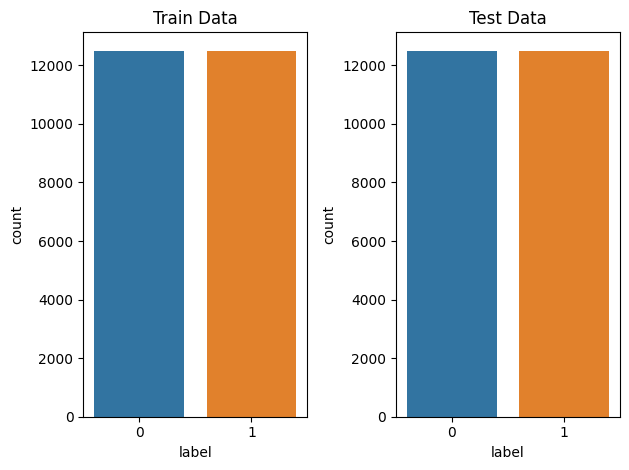

Train data length: 25000
Number of instances of class 0 in train data: 12500
Number of instances of class 1 in train data: 12500
Test data length: 25000
Number of instances of class 0 in test data: 12500
Number of instances of class 1 in test data: 12500


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2)

sns.countplot(x="label", data=train_data, ax=axes[0])
axes[0].set_title("Train Data")

sns.countplot(x="label", data=test_data, ax=axes[1])
axes[1].set_title("Test Data")

plt.tight_layout()
plt.show()

# Print information about the train data
print(f"Train data length: {len(train_data)}")
print(f"Number of instances of class 0 in train data: {sum(train_data['label'] == 0)}")
print(f"Number of instances of class 1 in train data: {sum(train_data['label'] == 1)}")

# Print information about the test data
print(f"Test data length: {len(test_data)}")
print(f"Number of instances of class 0 in test data: {sum(test_data['label'] == 0)}")
print(f"Number of instances of class 1 in test data: {sum(test_data['label'] == 1)}")

In [6]:
# Remove HTML tags
train_data['text'] = train_data['text'].apply(remove_html_tags)
test_data['text'] = test_data['text'].apply(remove_html_tags)

<ipython-input-3-273477798574>:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [7]:
from sklearn.model_selection import train_test_split
# Split the data into training and validation
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

In [8]:
# Separate the features and the labels
text_X_train = train_data['text']
y_train = train_data['label']

text_X_val = val_data['text']
y_val = val_data['label']

text_X_test = test_data['text']
y_test = test_data['label']

In [9]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
# Define the device
device = "cuda:0" if torch.cuda.is_available() else "cpu"
# Load the tokenizer (converts text to tokens)
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")

# Load the pre-trained model
transformer_model = AutoModelForSequenceClassification.from_pretrained(
   "cardiffnlp/twitter-roberta-base-sentiment-latest"
)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [10]:
# Added max_length to 512, apparently the maximum length for the "cardiffnlp/twitter-roberta-base-sentiment-latest" model is 514 tokens
# For our data this would end in a RuntimeError: The expanded size of the tensor (653) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 653].  Tensor sizes: [1, 514]
import numpy as np
import tqdm
def text_to_tensor(
   list_text_X_train: list,
   transformer_model: AutoModelForSequenceClassification,
   tokenizer: AutoTokenizer,
   device: str,
   max_length: int = 512,  # Set the maximum length
) -> np.ndarray:
   tokenized_text_X_train_split = [
       tokenizer.encode(text_x_train, return_tensors="pt", max_length=max_length, truncation=True, padding='max_length')
       for text_x_train in list_text_X_train
   ]
   transformer_model = transformer_model.to(device)
   output_hidden_states_list = [None] * len(tokenized_text_X_train_split)
   for i, tokenized_x in enumerate(tqdm.tqdm(tokenized_text_X_train_split)):
       output_hidden_states = transformer_model(tokenized_x.to(device), output_hidden_states=True)[
           1
       ][-1]
       output_hidden_states = output_hidden_states.mean(dim=1)
       output_hidden_states = output_hidden_states.detach().cpu().numpy()
       output_hidden_states_list[i] = output_hidden_states
   return np.concatenate(output_hidden_states_list, axis=0)

In [11]:
# Transform the text into tensors
list_text_X_train = text_X_train.tolist()
list_text_X_val = text_X_val.tolist()
list_text_X_test = text_X_test.tolist()

X_train_transformer = text_to_tensor(list_text_X_train, transformer_model, tokenizer, device)
X_val_transformer = text_to_tensor(list_text_X_val, transformer_model, tokenizer, device)
X_test_transformer = text_to_tensor(list_text_X_test, transformer_model, tokenizer, device)

100%|██████████| 25000/25000 [14:34<00:00, 28.60it/s]


In [12]:
from concrete.ml.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV
# Let's build our model
model = XGBClassifier()

# A gridsearch to find the best parameters
parameters = {
    "n_bits": [2, 3],
    "max_depth": [1],
    "n_estimators": [10, 30, 50],
    "n_jobs": [-1],
}

# Now we have a representation for each tweet, we can train a model on these.
grid_search = GridSearchCV(model, parameters, cv=5, n_jobs=1, scoring="accuracy")
grid_search.fit(X_train_transformer, y_train)

# Check the accuracy of the best model
print(f"Best score: {grid_search.best_score_}")

# Check best hyperparameters
print(f"Best parameters: {grid_search.best_params_}")

# Extract best model
best_model = grid_search.best_estimator_

Best score: 0.8683500000000001
Best parameters: {'max_depth': 1, 'n_bits': 3, 'n_estimators': 50, 'n_jobs': -1}


Accuracy: 0.8664
F1 Score: 0.8644


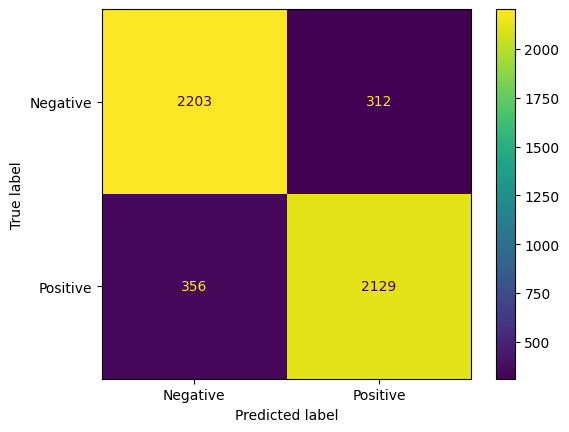

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# Compute the metrics on the test set
y_pred_val = best_model.predict(X_val_transformer)
y_proba_val = best_model.predict_proba(X_val_transformer)

matrix = confusion_matrix(y_val, y_pred_val)
ConfusionMatrixDisplay(matrix, display_labels=['Negative', 'Positive']).plot(values_format='.0f')

accuracy_transformer_xgboost = accuracy_score(y_val, y_pred_val)
f1score_transformer_xgboost = f1_score(y_val, y_pred_val)

print(f"Accuracy: {accuracy_transformer_xgboost:.4f}")
print(f"F1 Score: {f1score_transformer_xgboost:.4f}")

In [14]:
import time
# Compile the model to get the FHE inference engine
# (this may take a few minutes depending on the selected model)
start = time.perf_counter()
best_model.compile(X_train_transformer)
end = time.perf_counter()
print(f"Compilation time: {end - start:.4f} seconds")

Compilation time: 18.0042 seconds


In [15]:
# Let's write a custom example and predict in FHE
tested_review = ["This movie is fantastic! I really like it because it is so good!"]
X_tested_review = text_to_tensor(tested_review, transformer_model, tokenizer, device)
clear_proba = best_model.predict_proba(X_tested_review)

# Now let's predict with FHE over a single sentence and print the time it takes
start = time.perf_counter()
decrypted_proba = best_model.predict_proba(X_tested_review, fhe='execute')
end = time.perf_counter()
fhe_exec_time = end - start
print(f"FHE inference time: {fhe_exec_time:.4f} seconds")

print(f"Probabilities from the FHE inference: {decrypted_proba}")
print(f"Probabilities from the clear model: {clear_proba}")

100%|██████████| 1/1 [00:00<00:00,  8.66it/s]


FHE inference time: 14.5873 seconds
Probabilities from the FHE inference: [[0.35401525 0.64598475]]
Probabilities from the clear model: [[0.35401525 0.64598475]]


# Measuring on TEST data

## Clear Model

In [21]:
# Make predictions with the clear model
start = time.perf_counter()
y_pred_clear = best_model.predict(X_test_transformer)
end = time.perf_counter()
clear_exec_time = end - start
print(f"Clear inference time: {clear_exec_time:.4f} seconds")

Clear inference time: 2.6525 seconds


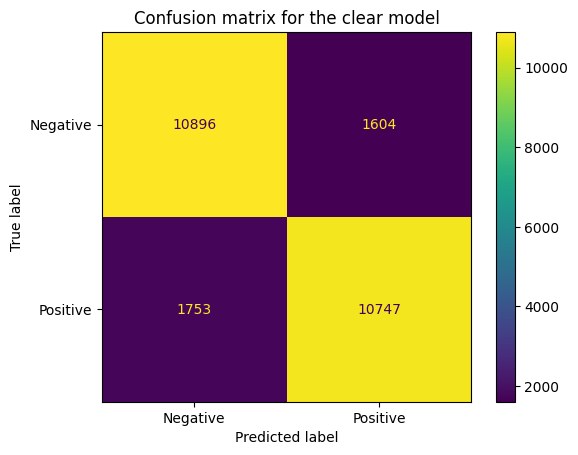

Clear model Accuracy: 0.8657
Clear model F1 Score: 0.8649


In [22]:
# Calculate and print performance metrics for the clear model
matrix = confusion_matrix(y_test, y_pred_clear)
ConfusionMatrixDisplay(matrix, display_labels=['Negative', 'Positive']).plot(values_format='.0f')
plt.title("Confusion matrix for the clear model")
plt.show()

accuracy_clear = accuracy_score(y_test, y_pred_clear)
f1score_clear = f1_score(y_test, y_pred_clear)

print(f"Clear model Accuracy: {accuracy_clear:.4f}")
print(f"Clear model F1 Score: {f1score_clear:.4f}")

## FHE model

In [ ]:
# # Correct version - full length (25k)
# # Make predictions with the FHE model
# start = time.perf_counter()
# y_pred_fhe = best_model.predict(X_test_transformer, fhe='execute')
# end = time.perf_counter()
# fhe_exec_time = end - start
# print(f"FHE inference time: {fhe_exec_time:.4f} seconds")

In [ ]:
# # Correct version - full length (25k)
# # Calculate and print performance metrics for the FHE model
# matrix = confusion_matrix(y_test, y_pred_fhe)
# ConfusionMatrixDisplay(matrix, display_labels=['Negative', 'Positive']).plot(values_format='.0f')
# plt.title("Confusion matrix for the FHE model")
# plt.show()

# accuracy_fhe = accuracy_score(y_test, y_pred_fhe)
# f1score_fhe = f1_score(y_test, y_pred_fhe)

# print(f"FHE model Accuracy: {accuracy_fhe:.4f}")
# print(f"FHE model F1 Score: {f1score_fhe:.4f}")

# FHE vs CLEAR sample comparison

In [25]:
# Define random state for reproducibility
random_state = 42

# Select random 100 samples from the test data
random_sample_indices = y_test.sample(100, random_state=random_state).index
X_test_transformer_sample = X_test_transformer[random_sample_indices]
y_test_sample = y_test[random_sample_indices]

Clear model accuracy: 0.8400
Clear model F1 Score: 0.8491


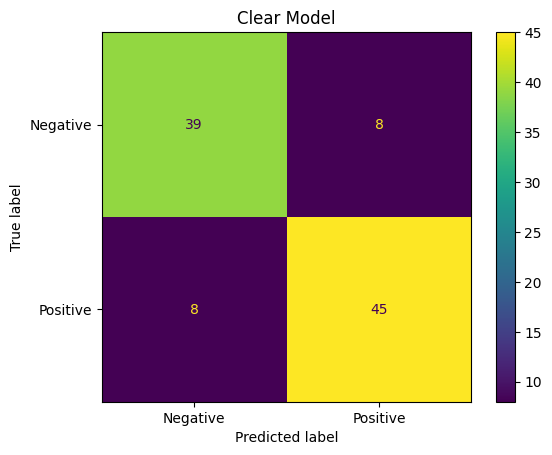

In [26]:
# Make predictions with the clear model
y_pred_clear = best_model.predict(X_test_transformer_sample)

# Compute and print accuracy and confusion matrix for clear model
matrix_clear = confusion_matrix(y_test_sample, y_pred_clear)
ConfusionMatrixDisplay(matrix_clear, display_labels=['Negative', 'Positive']).plot(values_format='.0f')
plt.title('Clear Model')

accuracy_clear = accuracy_score(y_test_sample, y_pred_clear)
f1score_clear = f1_score(y_test_sample, y_pred_clear)

print(f"Clear model accuracy: {accuracy_clear:.4f}")
print(f"Clear model F1 Score: {f1score_clear:.4f}")

FHE inference time: 557.7902 seconds
FHE model accuracy: 0.8400
FHE model F1 Score: 0.8491


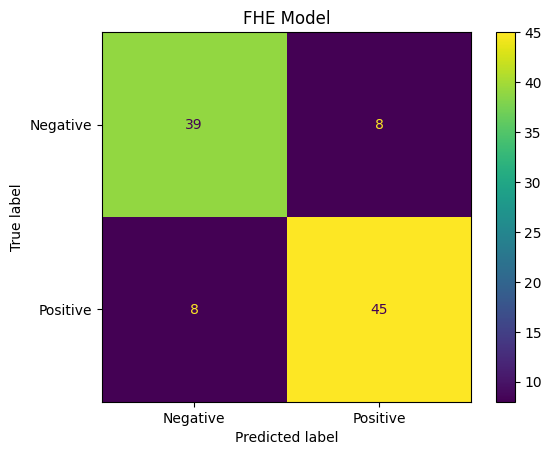

In [27]:
# Make predictions with the FHE model
start = time.perf_counter()
y_pred_fhe = best_model.predict(X_test_transformer_sample, fhe='execute')
end = time.perf_counter()

print(f"FHE inference time: {end - start:.4f} seconds")

# Compute and print accuracy and confusion matrix for FHE model
matrix_fhe = confusion_matrix(y_test_sample, y_pred_fhe)
ConfusionMatrixDisplay(matrix_fhe, display_labels=['Negative', 'Positive']).plot(values_format='.0f')
plt.title('FHE Model')

accuracy_fhe = accuracy_score(y_test_sample, y_pred_fhe)
f1score_fhe = f1_score(y_test_sample, y_pred_fhe)

print(f"FHE model accuracy: {accuracy_fhe:.4f}")
print(f"FHE model F1 Score: {f1score_fhe:.4f}")